## ZADANIE DOMOWE:

Wykorzystując zdobytą dotychczas wiedzę doprowadź do rozpoznania i separacji (wydzielenia) obiektów widocznych na obrazie "details.png" (https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/details.png).

Obiekty należą do trzech różnych klas: śrubki, nakrętki oraz podkładki.

Rozpoznanie powinno być dokonane na podstawie momentów, po wcześniejszej wstępnej obróbce obrazu oraz binaryzacji (segmentacji) - w miarę możliwości należy wyeliminować różnice w oświetleniu sceny, odblaski oraz cienie rzucane przez obiekty.

Końcowym rezultatem zadania mają być trzy obrazy zawierające tylko obiekty należące do danej klasy (osobno śrubki, osobno nakrętki i osobno podkładki).

Do zapisania zadania wykorzystaj nowy notebook lub ewentualnie użyj tego z zadaniem obowiązkowym (po usunięciu zbędnych opisów i fragmentów kodu).

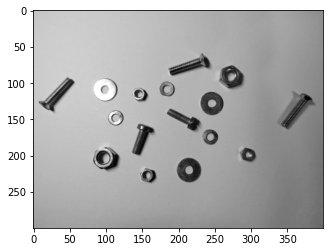

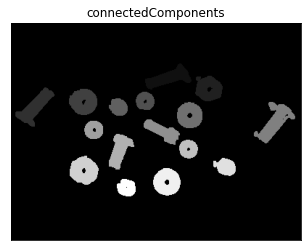

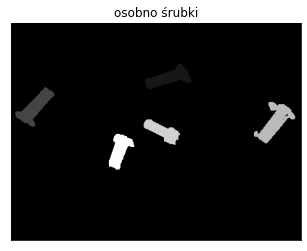

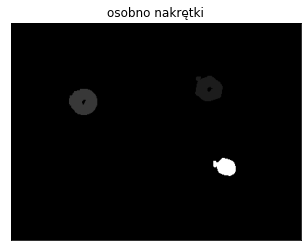

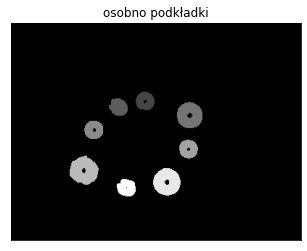

In [127]:

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

if not os.path.exists("details.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/13_CCL/details.png

details = cv2.imread('details.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(details, cmap = 'gray')
plt.show()
img = details
blur = cv2.GaussianBlur(img,(3,3),0)

ret1, img1 = cv2.threshold(blur, 210, 255, cv2.THRESH_BINARY_INV)
for i in range(blur.shape[0]):
    for j in range(blur.shape[1]):
        if img1[i,j] < 50:
            blur[i,j] = 100

top = cv2.morphologyEx(blur, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10)))

ret, img = cv2.threshold(top, 5, 255, cv2.THRESH_BINARY)

lowThresholdRatio=0.4
highThresholdRatio=0.95
TH = details.max() * highThresholdRatio
TL = TH * lowThresholdRatio

after_canny = cv2.Canny(details, TL, TH, None, 3, 1)

img_pom = 255 - after_canny - img
img_e = cv2.morphologyEx(img_pom, cv2.MORPH_ERODE, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))
for i in range(img_e.shape[0]):
    for j in range(img_e.shape[1]):
        if img1[i,j] < 10:
            img_e[i,j] = 0
img_e = 255 - img_e


shapes_id = cv2.connectedComponents(img_e)
plt.imshow(shapes_id[1], 'gray')

plt.title('connectedComponents')
plt.xticks([]), plt.yticks([])
plt.show()

image_idx = cv2.connectedComponentsWithStats(img_e)
ccl_vis = image_idx[1].copy()
for i in range(1, image_idx[0]):
    cv2.putText(ccl_vis, str(i),(int(image_idx[3][i, 0]),int(image_idx[3][i, 1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (20, 0, 0), 2)
# plt.imshow(ccl_vis, 'gray')
# plt.show()


mat = []

for s in range(1, shapes_id[0]):
    I = (shapes_id[1] == s)*1
    I = I.astype('uint8')
    moment = cv2.moments(I)
    Hu_mom = cv2.HuMoments(moment)
    mat.append(Hu_mom)

# print(np.array(mat))

img = shapes_id[1].copy()
height, width = img.shape

prog = 0.2
for x in range(len(mat)):
    if mat[x][0][0] < prog:
        for i in range(height):
            for j in range(width):
                if img[i, j] == x+1:
                    img[i, j] = 0

plt.imshow(img, 'gray')

plt.title('osobno śrubki')
plt.xticks([]), plt.yticks([])
plt.show()

shapes_id2 = cv2.connectedComponents(img_e)
img1 = shapes_id2[1].copy()
height, width = img1.shape
prog = 0.2
for x in range(len(mat)):
    if mat[x][0][0] > prog:
        for i in range(height):
            for j in range(width):
                if img1[i, j] == x+1:
                    img1[i, j] = 0

for i in range(img1.shape[0]):
    for j in range(img1.shape[1]):
        if img1[i,j] != 0:
            img1[i,j] = 255
img1 = img1.astype('uint8')
shapes_id3 = cv2.connectedComponents(img1)

mat = []

for s in range(1, shapes_id3[0]):
    I = (shapes_id3[1] == s)*1
    I = I.astype('uint8')
    moment = cv2.moments(I)
    Hu_mom = cv2.HuMoments(moment)
    mat.append(Hu_mom)
img1 = shapes_id3[1].copy()

for x in range(len(mat)):
    if mat[x][2][0] < 2e-05:
        for i in range(height):
            for j in range(width):
                if img1[i, j] == x+1:
                    img1[i, j] = 0
plt.imshow(img1, 'gray')

plt.title('osobno nakrętki')
plt.xticks([]), plt.yticks([])
plt.show()

img2 = shapes_id3[1].copy()

for x in range(len(mat)):
    if mat[x][2][0] > 2e-05:
        for i in range(height):
            for j in range(width):
                if img2[i, j] == x+1:
                    img2[i, j] = 0
plt.imshow(img2, 'gray')

plt.title('osobno podkładki')
plt.xticks([]), plt.yticks([])
plt.show()

Wynik jest nie do końca satysfakcjonujący, ponieważ po próbie wyróżnienia obiektów, różnice między podkładkami a nakrętkami się zatarły.